# import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.executable

'/home/lcances/.miniconda3/envs/dct/bin/python'

In [3]:
import os
os.environ["MKL_NUM_THREADS"] = "2"
os.environ["NUMEXPR_NU M_THREADS"] = "2"
os.environ["OMP_NUM_THREADS"] = "2"
import time

import numpy
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.cuda.amp import autocast

from torch.optim.lr_scheduler import LambdaLR
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader

In [4]:
from SSL.util.model_loader import load_model
from SSL.util.loaders import load_dataset, load_optimizer, load_callbacks, load_preprocesser
from SSL.util.checkpoint import CheckPoint, mSummaryWriter
from SSL.util.utils import reset_seed, get_datetime, track_maximum, DotDict

from metric_utils.metrics import CategoricalAccuracy, FScore, ContinueAverage

# Arguments

In [36]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--from_config", default="", type=str)
parser.add_argument("-d", "--dataset_root", default="../datasets", type=str)
parser.add_argument("-D", "--dataset", default="esc10", type=str, help="available [ubs8k | cifar10]")

group_t = parser.add_argument_group("Commun parameters")
group_t.add_argument("-m", "--model", default="cnn03", type=str)
group_t.add_argument("--supervised_ratio", default=1.0, type=float)
group_t.add_argument("--batch_size", default=64, type=int)
group_t.add_argument("--nb_epoch", default=100, type=int)
group_t.add_argument("--learning_rate", default=0.003, type=float)
group_t.add_argument("--resume", action="store_true", default=False)
group_t.add_argument("--preload_dataset", action="store_true", default=False)
group_t.add_argument("--seed", default=1234, type=int)

group_m = parser.add_argument_group("Model parameters")
group_m.add_argument("--num_classes", default=10, type=int)

group_u = parser.add_argument_group("Datasets parameters")
group_u.add_argument("-t", "--train_folds", nargs="+", default=[1, 2, 3, 4], type=int)
group_u.add_argument("-v", "--val_folds", nargs="+", default=[5], type=int)

group_l = parser.add_argument_group("Logs")
group_l.add_argument("--checkpoint_root", default="../model_save/", type=str)
group_l.add_argument("--tensorboard_root", default="../tensorboard/", type=str)
group_l.add_argument("--checkpoint_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_path", default="supervised", type=str)
group_l.add_argument("--tensorboard_sufix", default="", type=str)

args = parser.parse_args("")

args.tensorboard_path = os.path.join(args.tensorboard_root, args.dataset, args.tensorboard_path)
args.checkpoint_path = os.path.join(args.checkpoint_root, args.dataset, args.checkpoint_path)

In [ ]:
vars(args)

# initialisation

In [7]:
reset_seed(args.seed)


trainer = SupervisedTrainer("cnn03", "esc10")
trainer.init_trainer(
    parameters=vars(args),
    seed = args.seed,
    num_workers=0,
    pin_memory=True,
    verbose = 2
)

In [8]:
# from SSL.trainers.esc import SupervisedTrainer
from SSL.trainers.trainers import Trainer

class SupervisedTrainer(Trainer):
    def __init__(self, model: str, dataset: str):
        super().__init__(model, "supervised", dataset)

trainer = SupervisedTrainer(args.model, args.dataset)

# Prepare the dataset

In [9]:
trainer.load_transforms()

Load the transformation
################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
parameters = dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    
    num_workers=0,
    pin_memory=True,

    verbose = 2,
)

trainer.load_dataset(parameters)

Load the dataset
Dataset already downloaded and verified.
Dataset already downloaded and verified.


# Prep model

In [11]:
trainer.create_model()


Create the model
1872 10
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 64, 431]             240
         MaxPool2d-2          [-1, 24, 16, 215]               0
       BatchNorm2d-3          [-1, 24, 16, 215]              48
             ReLU6-4          [-1, 24, 16, 215]               0
            Conv2d-5          [-1, 48, 16, 215]          10,416
         MaxPool2d-6           [-1, 48, 4, 107]               0
       BatchNorm2d-7           [-1, 48, 4, 107]              96
             ReLU6-8           [-1, 48, 4, 107]               0
            Conv2d-9           [-1, 72, 4, 107]          31,176
        MaxPool2d-10            [-1, 72, 2, 53]               0
      BatchNorm2d-11            [-1, 72, 2, 53]             144
            ReLU6-12            [-1, 72, 2, 53]               0
           Conv2d-13            [-1, 72, 2, 53]          46,728
        MaxPoo

In [9]:
from torchsummary import summary

s = summary(trainer.model, trainer.input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 64, 431]             240
         MaxPool2d-2          [-1, 24, 16, 215]               0
       BatchNorm2d-3          [-1, 24, 16, 215]              48
             ReLU6-4          [-1, 24, 16, 215]               0
            Conv2d-5          [-1, 48, 16, 215]          10,416
         MaxPool2d-6           [-1, 48, 4, 107]               0
       BatchNorm2d-7           [-1, 48, 4, 107]              96
             ReLU6-8           [-1, 48, 4, 107]               0
            Conv2d-9           [-1, 72, 4, 107]          31,176
        MaxPool2d-10            [-1, 72, 2, 53]               0
      BatchNorm2d-11            [-1, 72, 2, 53]             144
            ReLU6-12            [-1, 72, 2, 53]               0
           Conv2d-13            [-1, 72, 2, 53]          46,728
        MaxPool2d-14            [-1, 72

# Training initialization

## Losses

In [12]:
from types import MethodType

def init_loss(self):
    self.loss_ce = nn.CrossEntropyLoss(reduction="mean")

trainer.init_loss = MethodType(init_loss, trainer)

In [13]:
trainer.init_loss()

## optimizer & callbacks

In [14]:
parameters=DotDict(
    learning_rate=args.learning_rate,
)
trainer.init_optimizer(parameters)


Initialize optimizer


In [15]:
parameters=DotDict(
    nb_epoch=args.nb_epoch,
    optimizer=trainer.optimizer,
)
trainer.init_callbacks(parameters)

Initialize callbacks


# Logs and checkpoint

In [16]:
# Logs
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_logs(parameters)

# Save all the parameters
tensorboard_params = {}
for key, value in args.__dict__.items():
    tensorboard_params[key] = str(value)
trainer.tensorboard.add_hparams(tensorboard_params, {})


Prepare the log system


In [17]:
# Checkpoint
parameters=DotDict(
    supervised_ratio=args.supervised_ratio
)
trainer.init_checkpoint(parameters)

Prepare the checkpoint system


## Metrics

In [18]:
# Metrics
def init_metrics(self):
    self.metrics = DotDict(
        fscore_fn=FScore(),
        acc_fn=CategoricalAccuracy(),
        avg_fn=ContinueAverage(),
    )
    self.maximum_tracker = track_maximum()

trainer.init_metrics = MethodType(init_metrics, trainer)
trainer.init_metrics()

## training function

In [19]:
def set_printing_form(self):
    UNDERLINE_SEQ = "\033[1;4m"
    RESET_SEQ = "\033[0m"

    header_form = "{:<8.8} {:<6.6} - {:<6.6} - {:<8.8} {:<6.6} - {:<9.9} {:<12.12}| {:<9.9}- {:<6.6}"
    value_form  = "{:<8.8} {:<6} - {:<6} - {:<8.8} {:<6.4f} - {:<9.9} {:<10.4f}| {:<9.4f}- {:<6.4f}"

    self.header = header_form.format(
        ".               ", "Epoch", "%", "Losses:", "ce", "metrics: ", "acc", "F1 ","Time"
    )

    self.train_form = value_form
    self.val_form = UNDERLINE_SEQ + value_form + RESET_SEQ

In [20]:
def train_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.train_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.train()

    for i, (X, y) in enumerate(self.train_loader):
        X = X.cuda()
        y = y.cuda()

        logits = self.model(X)
        loss = self.loss_ce(logits, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.set_grad_enabled(False):
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=self.num_classes)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y_one_hot).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.train_form.format(
                "Training: ",
                epoch + 1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    T("train/Lce", avg_ce, epoch)
    T("train/f1", fscore, epoch)
    T("train/acc", acc, epoch)

In [21]:
def val_fn(self, epoch: int):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.val_loader)

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(self.val_loader):
            X = X.cuda()
            y = y.cuda()

            logits = self.model(X)
            loss = self.loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=self.num_classes)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y_one_hot).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.val_form.format(
                "Validation: ",
                epoch + 1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

    T("val/Lce", avg_ce, epoch)
    T("val/f1", fscore, epoch)
    T("val/acc", acc, epoch)

    T("hyperparameters/learning_rate", self._get_lr(), epoch)

    T("max/acc", self.maximum_tracker("acc", acc), epoch)
    T("max/f1", self.maximum_tracker("f1", fscore), epoch)

    self.checkpoint.step(acc)
    for c in self.callbacks:
        c.step()
        pass

In [22]:
def test_fn(self):
    # aliases
    M = self.metrics
    T = self.tensorboard.add_scalar
    nb_batch = len(self.val_loader)

    # Load best epoch
    self.checkpoint.load_best()

    start_time = time.time()
    print("")

    self.reset_metrics()
    self.model.eval()

    with torch.set_grad_enabled(False):
        for i, (X, y) in enumerate(self.test_loader):
            X = X.cuda()
            y = y.cuda()

            logits = self.model(X)
            loss = self.loss_ce(logits, y)

            # metrics
            pred = torch.softmax(logits, dim=1)
            pred_arg = torch.argmax(logits, dim=1)
            y_one_hot = F.one_hot(y, num_classes=self.num_classes)

            acc = M.acc_fn(pred_arg, y).mean
            fscore = M.fscore_fn(pred, y_one_hot).mean
            avg_ce = M.avg_fn(loss.item()).mean

            # logs
            print(self.val_form.format(
                "Testing: ",
                1,
                int(100 * (i + 1) / nb_batch),
                "", avg_ce,
                "", acc, fscore,
                time.time() - start_time
            ), end="\r")

In [23]:
trainer.set_printing_form = MethodType(set_printing_form, trainer)
trainer.train_fn = MethodType(train_fn, trainer)
trainer.val_fn = MethodType(val_fn, trainer)
trainer.test_fn = MethodType(test_fn, trainer)

# Training

In [24]:
# Fit function
trainer.set_printing_form()
print(trainer.header)

start_epoch = trainer.checkpoint.epoch_counter
end_epoch = args.nb_epoch

for e in range(start_epoch, args.nb_epoch):
    trainer.train_fn(e)
    trainer.val_fn(e)
    
    trainer.tensorboard.flush()

.        Epoch  - %      - Losses:  ce     - metrics:  acc         | F1       - Time  

Training 1      - 100    -          2.0345 -           0.2656    | 0.0965   - 1.8694
Validati 1      - 100    -          2.6831 -           0.1953    | 0.2777   - 0.3721
Training 2      - 100    -          1.2135 -           0.5469    | 0.4048   - 0.1758
Validati 2      - 100    -          2.9214 -           0.3047    | 0.2911   - 0.0132
Training 3      - 100    -          0.8702 -           0.6656    | 0.6131   - 0.1616
Validati 3      - 100    -          2.5288 -           0.2422    | 0.2589   - 0.0124
Training 4      - 100    -          0.7645 -           0.6656    | 0.6485   - 0.1618
Validati 4      - 100    -          1.7741 -           0.4922    | 0.5164   - 0.0126
Training 5      - 100    -          0.5648 -           0.7781    | 0.7831   - 0.1715
Validati 5      - 100    -          1.2882 -           0.6953    | 0.6906   - 0.0137
Training 6      - 100    -          0.4015 -           0.8469 

In [25]:
if args.dataset.lower() == "speechcommand":
    trainer.test_fn()

## display

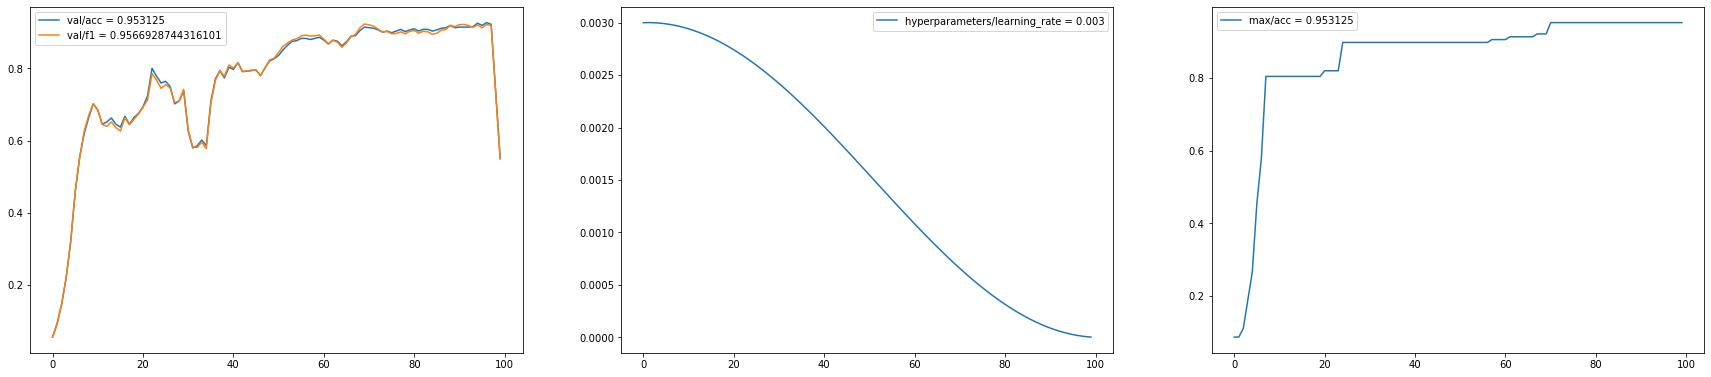

In [32]:
import matplotlib.pyplot as plt
import numpy as np

T=trainer.tensorboard.history

x = list(range(trainer.checkpoint.epoch_counter))
sm = lambda y, w: np.convolve(y, np.ones(w)/w, mode='same')
pp = lambda k: plt.plot(x, T[k], label=f"{k} = {max(T[k])}")
spp = lambda k: plt.plot(x, sm(T[k], 5), label=f"{k} = {max(T[k])}")


plt.figure(0, figsize=(30, 14))
plt.subplot(2, 3, 1)
spp("val/acc")
spp("val/f1")
plt.legend()

plt.subplot(2, 3, 2)
pp("hyperparameters/learning_rate")
plt.legend()

plt.subplot(2, 3, 3)
pp("max/acc")
plt.legend()

plt.show()

# ♫♪.ılılıll|̲̅̅●̲̅̅|̲̅̅=̲̅̅|̲̅̅●̲̅̅|llılılı.♫♪

In [33]:
from SSL.trainers import SupervisedTrainer

training_params=dict(
    dataset=args.dataset,

    dataset_root = args.dataset_root,
    supervised_ratio = args.supervised_ratio,
    batch_size = args.batch_size,
    train_folds = args.train_folds,
    val_folds = args.val_folds,
    learning_rate=args.learning_rate,
    nb_epoch=args.nb_epoch,
    seed=args.seed,

)
other_params = dict(
    num_workers=0,
    pin_memory=True,
    verbose = 2,
)

trainer = SupervisedTrainer("cnn03", "esc10")
trainer.init_trainer(
    training_params,
    **other_params
    
)

Load the transformation
Load the dataset
Dataset already downloaded and verified.
Dataset already downloaded and verified.
Create the model
1872 10
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 24, 64, 431]             240
         MaxPool2d-2          [-1, 24, 16, 215]               0
       BatchNorm2d-3          [-1, 24, 16, 215]              48
             ReLU6-4          [-1, 24, 16, 215]               0
            Conv2d-5          [-1, 48, 16, 215]          10,416
         MaxPool2d-6           [-1, 48, 4, 107]               0
       BatchNorm2d-7           [-1, 48, 4, 107]              96
             ReLU6-8           [-1, 48, 4, 107]               0
            Conv2d-9           [-1, 72, 4, 107]          31,176
        MaxPool2d-10            [-1, 72, 2, 53]               0
      BatchNorm2d-11            [-1, 72, 2, 53]             144
            ReLU6-1

In [28]:
trainer.fit()


Training 1      - 100    -          2.0345 -           0.2656    | 0.0965   - 1.8048
Validati 1      - 100    -          2.6831 -           0.1953    | 0.2777   - 0.4444
Training 2      - 100    -          1.2135 -           0.5469    | 0.4048   - 0.1740
Validati 2      - 100    -          2.9214 -           0.3047    | 0.2911   - 0.0137
Training 3      - 100    -          0.8702 -           0.6656    | 0.6131   - 0.1736
Validati 3      - 100    -          2.5288 -           0.2422    | 0.2589   - 0.0122
Training 4      - 100    -          0.7645 -           0.6656    | 0.6485   - 0.1747
Validati 4      - 100    -          1.7741 -           0.4922    | 0.5164   - 0.0137
Training 5      - 100    -          0.5648 -           0.7781    | 0.7831   - 0.1631
Validati 5      - 100    -          1.2882 -           0.6953    | 0.6906   - 0.0140
Training 6      - 100    -          0.4015 -           0.8469    | 0.8583   - 0.1590
Validati 6      - 100    -          3.0976 -           0.5625   

In [42]:
trainer = SupervisedTrainer("cnn03", "esc10")

train_folds = [[1, 2, 3, 4],
               [2, 3, 4, 5],
               [3, 4, 5, 1],
               [4, 5, 1, 2],
               [5, 1, 2, 3]]
val_folds = [[5], [1], [2], [3], [4]]

for tf, vf in zip(train_folds, val_folds):
    training_params["train_folds"] = tf
    training_params["val_folds"] = vf

    print(tf, vf)
    trainer.init_trainer(
        training_params,
        **other_params
    )
    print(trainer.parameters)

    #trainer.fit()
    # trainer.close()

   [-1, 32, 32, 216]               0
           Conv2d-15          [-1, 32, 32, 216]           9,216
      BatchNorm2d-16          [-1, 32, 32, 216]              64
             ReLU-17          [-1, 32, 32, 216]               0
       BasicBlock-18          [-1, 32, 32, 216]               0
           Conv2d-19          [-1, 32, 32, 216]           9,216
      BatchNorm2d-20          [-1, 32, 32, 216]              64
             ReLU-21          [-1, 32, 32, 216]               0
           Conv2d-22          [-1, 32, 32, 216]           9,216
      BatchNorm2d-23          [-1, 32, 32, 216]              64
             ReLU-24          [-1, 32, 32, 216]               0
       BasicBlock-25          [-1, 32, 32, 216]               0
           Conv2d-26          [-1, 32, 32, 216]           9,216
      BatchNorm2d-27          [-1, 32, 32, 216]              64
             ReLU-28          [-1, 32, 32, 216]               0
           Conv2d-29          [-1, 32, 32, 216]           9,216
   